# The moments of the distribution for mRNA and protein in a two- and three-state promoter.

(c) 2017 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT)

In [1]:
import glob
# Our numerical workhorses
import numpy as np
import scipy.optimize
import scipy.special
import scipy.integrate
import mpmath
# To compute symbolic expressions
import sympy
sympy.init_printing(use_unicode=True, fontsize=4) # print outputs in LaTeX

import pandas as pd
# Import libraries to parallelize processes
from joblib import Parallel, delayed

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the utils for this project
import chann_cap_utils as chann_cap

# Set PBoC plotting style
chann_cap.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

# figdir = '../../fig/chemical_master_analytic_mRNA/'
# tmpdir = '../../tmp/'

### $\LaTeX$ macros
$\newcommand{kpon}{k^p_{\text{on}}}$
$\newcommand{kpoff}{k^p_{\text{off}}}$
$\newcommand{kron}{k^r_{\text{on}}}$
$\newcommand{kroff}{k^r_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{mm}{\left\langle m \right\rangle}$

# Two-state promoter (mRNA)

In this section we will perform the linear algebra to solve for the steady-state moments of the mRNA distribution.

Up to this stage we wrote the chemical master equation in matrix notation and did some tricks when it came to compute the $n^{\text{th}}$ moment. Now we will use the equations we obtained for the time derivative of the mRNA distribution moments and set that to steady-state to solve for the moments themselves.

Let's first define the `sympy` variables that we will need for the two- and three-state promoter.

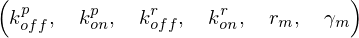

In [2]:
# Define rate constant variables
kp_off, kp_on = sympy.symbols('k_{off}^p k_{on}^p')
kr_off, kr_on = sympy.symbols('k_{off}^r k_{on}^r')

# Define degradation rate and production rate
rm, gm = sympy.symbols('r_m gamma_m')

kp_off, kp_on, kr_off, kr_on, rm, gm

Let's now define a function that generates a `sympy` variable of the form $\left\langle x^n \right\rangle$ to easily define the variables to save the moments.

In [3]:
def moment_sympy(var, moment):
    '''
    Shortcut to generate variables of the form <var**n> in sympy to facilitate the
    definition of the moment variables
    Parameters
    ----------
    var : string.
        variable name string that should be put inside the <> parenthesis.
    moment : int.
        exponent of the moment to be defined.
    '''
    return sympy.Symbol('{\\langle ' + var + '^{:d}'.format(moment) + '\\rangle}')

Now let's define the moment variables for the unregulated promoter.

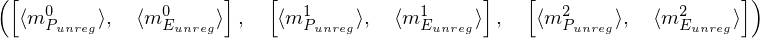

In [4]:
# Define the string for the states
m_unreg = ['m_{P_{unreg}}', 'm_{E_{unreg}}']

# Define the zeroth moments
m0_unreg = [moment_sympy(x, 0) for x in m_unreg]
# Define the first moments
m1_unreg = [moment_sympy(x, 1) for x in m_unreg]
# Define the second moments
m2_unreg = [moment_sympy(x, 2) for x in m_unreg]

m0_unreg, m1_unreg, m2_unreg

Now we will define the state transition matrix $\mathbf{K}^u$, the mRNA production matrix $\mathbf{R}^u_m$ and the mRNA degradation matrix $\mathbf{\Gamma}^u_m$.

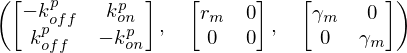

In [5]:
# Define the rate constant matrix
Kmat_unreg = sympy.Matrix([[-kp_off, kp_on], 
                           [kp_off, -kp_on]])
# Define the production matrix
Rmat_unreg = sympy.Matrix([[rm, 0], 
                           [0, 0]])
# Define the degradation matrix
Gmat_unreg = sympy.Matrix([[gm, 0],
                           [0, gm]])

Kmat_unreg, Rmat_unreg, Gmat_unreg

### Zeroth moment two-state promoter
In order to solve for the two-state promoter we have two equations to use
$$
1 = \mathbf{u} \cdot \left\langle \mathbf{m}^0 \right\rangle,
$$
where $u = (1, 1)$ and $\left\langle \mathbf{m}^0 \right\rangle$ is the vector containing all the states, and
$$
\mathbf{0} = \mathbf{K}^u_m \left\langle \mathbf{m}^0 \right\rangle.
$$

We will use the linear algebra solver where we write an extended matrix with the last column being the right hand side of these equations.

Let's now define this extended matrix.

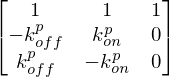

In [6]:
# Add the extra row for the normalization constraint
K_sys_unreg = Kmat_unreg.row_insert(0, sympy.Matrix([1, 1]).transpose())

# Define right-side array
b = sympy.Matrix([1, 0, 0])

# Define augmented matrix
zero_aug_unreg = K_sys_unreg.col_insert(2, b)
zero_aug_unreg

Now we solve the equation for the two state moments.

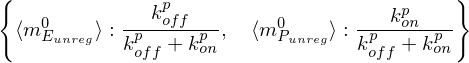

In [7]:
# Solve linear system for the three zeroth moments
zero_sol_unreg = sympy.solve_linear_system(zero_aug_unreg, *m0_unreg)
zero_sol_unreg

### First moment two-state promoter

Now that we have the zeroth moment that indicates the probability of being on either state let's now compute the first moment. For this we have the matrix equation
$$
\mathbf{0} = \left( \mathbf{K}^u_m - \mathbf{\Gamma}^u_m  \right)
             + \mathbf{R}^u_m \left\langle \mathbf{m}^0 \right\rangle.
$$

Let's write this system in the form of the augmented matrix.

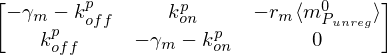

In [8]:
# Define augmented matrix for first moment
first_aug_unreg = (Kmat_unreg - Gmat_unreg).col_insert(2, 
                                            -Rmat_unreg * sympy.Matrix(m0_unreg))
first_aug_unreg

And again we use the `sympy` solver to solve for the first moments

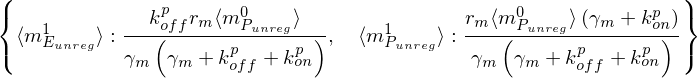

In [9]:
# Solve linear system for the three moments
first_sol_unreg = sympy.solve_linear_system(first_aug_unreg, *m1_unreg)
first_sol_unreg

We now sum both elements and substitute the solution for the zeroth moments

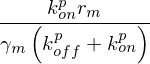

In [10]:
first_unreg = sympy.simplify(sum(first_sol_unreg.values()).subs(zero_sol_unreg))
first_unreg

### Second moment two-state promoter

Finally for the second moment we have an equation of the form
$$
\mathbf{0} = \left( \mathbf{K}^u_m - 2 \mathbf{\Gamma}^u_n \right) 
             \left\langle \mathbf{m}^2 \right\rangle
             + \left( 2 \mathbf{R}^u_m + \mathbf{\Gamma}^u_m \right)
             \left\langle \mathbf{m}^1 \right\rangle
             + \mathbf{R}^u_m
             \left\langle \mathbf{m}^0 \right\rangle
$$

Let's again define this augmented matrix.

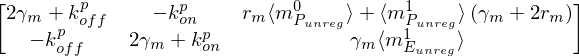

In [11]:
# Define augmented matrix for second moment
second_aug_unreg = (2 * Gmat_unreg - Kmat_unreg).col_insert(2, 
                   (2 * Rmat_unreg + Gmat_unreg) * sympy.Matrix(m1_unreg)\
                   + Rmat_unreg * sympy.Matrix(m0_unreg))
second_aug_unreg

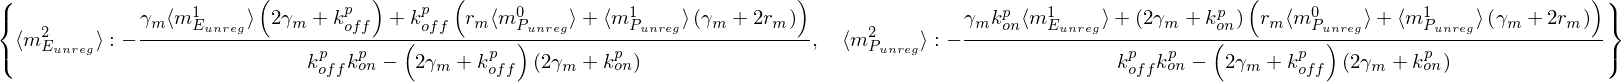

In [12]:
# Solve linear system for the three moments
second_sol_unreg = sympy.solve_linear_system(second_aug_unreg, *m2_unreg)
second_sol_unreg

Again let's add both of these moments to obtain the global second moment.

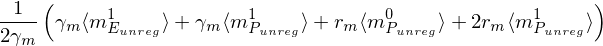

In [13]:
second_unreg = sympy.simplify(sum(second_sol_unreg.values()))
second_unreg

Let's now substitute the solution for the sum of the first moments.

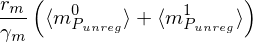

In [14]:
second_unreg_s = second_unreg.subs(gm * m1_unreg[0] + gm * m1_unreg[1], 
                  gm * sympy.simplify(sum(first_sol_unreg.values())))
sympy.simplify(second_unreg_s)

This is the answer shown in PBoC. Now is a matter of substituting the other solutions to obtain the second moment.

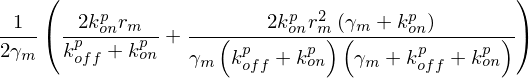

In [15]:
second_unreg_s.subs(first_sol_unreg).subs(zero_sol_unreg)

Let's now compute the variance and the fano-factor to confirm that we obtain the exact same results as derived in PBoC.

In [16]:
# Compute the variance of the unregulated promoter
var_unreg = second_unreg - first_unreg**2
var_unreg
# Compute the fano factor of the unregulated promoter
# fano_unreg = sympy.simplify(var_unreg / first_unreg)

# fano_unreg

                                                                              
γₘ⋅{\langle m_{E_{unreg}}__1\rangle} + γₘ⋅{\langle m_{P_{unreg}}__1\rangle} + 
──────────────────────────────────────────────────────────────────────────────
                                                                            2⋅
                                                                              

                                                                              
rₘ⋅{\langle m_{P_{unreg}}__0\rangle} + 2⋅rₘ⋅{\langle m_{P_{unreg}}__1\rangle} 
───────────────────────────────────────────────────────────────────────────── 
γₘ                                                                            
                                                                              

                   2   2       
          k_{on}__p ⋅rₘ        
- ─────────────────────────────
    2                         2
  γₘ ⋅(k_{off}__p + k_{on}__p) 

In [141]:
fano_pboc = 1 + kp_on / (kp_off + kp_on) * rm / (kp_off + kp_on + gm)
# sympy.simplify(fano_pboc - fano_unreg)

                         -rₘ⋅(k_{off}__p - k_{on}__p)                         
──────────────────────────────────────────────────────────────────────────────
                                         2                                    
γₘ⋅k_{off}__p + γₘ⋅k_{on}__p + k_{off}__p  + 2⋅k_{off}__p⋅k_{on}__p + k_{on}__

  
──
 2
p 

# Three-state promoter (mRNA)

In [83]:
# Define zeroth moment variables
mp_0 = sympy.Symbol('{\\langle m_P^0 \\rangle}')
me_0 = sympy.Symbol('{\\langle m_E^0 \\rangle}')
mr_0 = sympy.Symbol('{\\langle m_R^0 \\rangle}')

# Define first moment variables
mp_1 = sympy.Symbol('{\\langle m_P^1 \\rangle}')
me_1 = sympy.Symbol('{\\langle m_E^1 \\rangle}')
mr_1 = sympy.Symbol('{\\langle m_R^1 \\rangle}')

# Define second moment variables
mp_2 = sympy.Symbol('{\\langle m_P^2 \\rangle}')
me_2 = sympy.Symbol('{\\langle m_E^2 \\rangle}')
mr_2 = sympy.Symbol('{\\langle m_R^2 \\rangle}')


mp_0, me_0, mr_0, mp_1, me_1, mr_1, mp_2, me_2, mr_2

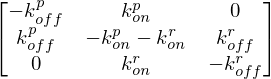

In [46]:
# Define the rate constant matrix
Kmat = sympy.Matrix([[-kp_off, kp_on, 0], 
                  [kp_off, -(kp_on + kr_on), kr_off],
                  [0, kr_on, -kr_off]])
Kmat

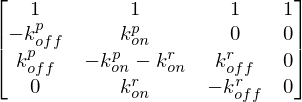

In [55]:
# Add the extra row for the normalization constraint
K_sys = Kmat.row_insert(0, sympy.Matrix([1, 1, 1]).transpose())

# Define right-side array
b = sympy.Matrix([1, 0, 0, 0])

# Define augmented matrix
zero_aug = K_sys.col_insert(3, b)
zero_aug

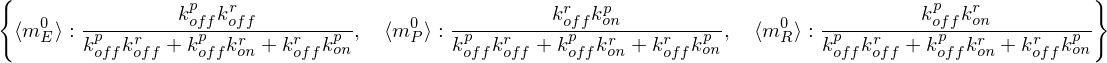

In [62]:
# Solve linear system for the three zeroth moments
zero_sol = sympy.solve_linear_system(zero_aug, mp_0, me_0, mr_0)
zero_sol

In [72]:
# Sum all elements to confirm it adds up to one
sympy.simplify(sum(zero_sol.values()))

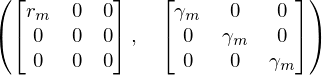

In [51]:
# Define R and Gamma matrices
Rmat = sympy.Matrix([[rm, 0, 0], [0, 0, 0], [0, 0, 0]])
Gmat = sympy.Matrix([[gm, 0, 0], [0, gm, 0], [0, 0, gm]])
Rmat, Gmat

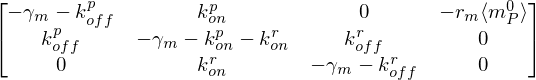

In [74]:
# Define array with zeroth moments
m0_array = sympy.Matrix([mp_0, me_0, mr_0])

# Define augmented matrix for first moment
first_aug = (Kmat - Gmat).col_insert(3, -Rmat * m0_array)
first_aug

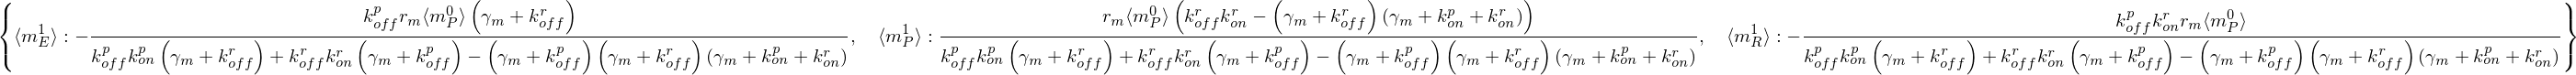

In [95]:
# Solve linear system for the three moments
first_sol = sympy.solve_linear_system(first_aug, mp_1, me_1, mr_1)
first_sol

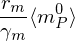

In [78]:
# Compute the first moment
sympy.simplify(sum(first_sol.values()))

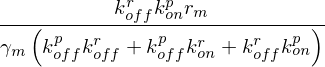

In [80]:
# Substitute the value of the mp_0 solution
sympy.simplify(sum(first_sol.values()).subs(mp_0, zero_sol[mp_0]))

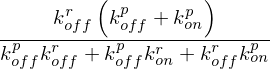

In [82]:
# Define the first moment of the two-state unregulated promoter
first_unreg = rm / gm * kp_on / (kp_off + kp_on)

# Compute the fold-change with this three state promoter
sympy.simplify(sum(first_sol.values()).subs(mp_0, zero_sol[mp_0]) / first_unreg)

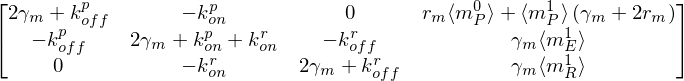

In [84]:
# Define array with zeroth moments
m1_array = sympy.Matrix([mp_1, me_1, mr_1])

# Define augmented matrix for first moment
second_aug = (2 * Gmat - Kmat).col_insert(3, 
                               (2 * Rmat + Gmat) * m1_array + Rmat * m0_array)
second_aug

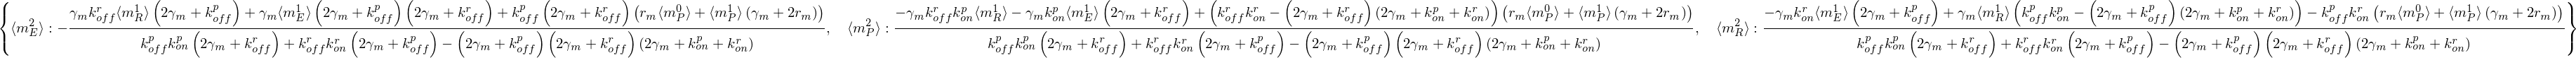

In [85]:
# Solve linear system for the three moments
second_sol = sympy.solve_linear_system(second_aug, mp_2, me_2, mr_2)
second_sol

In [90]:
sympy.simplify(sum(second_sol.values()).subs({**first_sol, **zero_sol}))

   ⎛                                  2                                       
rₘ⋅⎝γₘ⋅k_{off}__p⋅k_{off}__r⋅k_{on}__p ⋅(γₘ + k_{off}__r)⋅(2⋅γₘ + k_{off}__r) 
──────────────────────────────────────────────────────────────────────────────
                                                                              

                                                                              
+ γₘ⋅k_{off}__p⋅k_{off}__r⋅k_{on}__p⋅k_{on}__r⋅{\langle m_P__0 \rangle}⋅(k_{of
──────────────────────────────────────────────────────────────────────────────
                                                                              

                                                                              
f}__p⋅k_{off}__r + k_{off}__p⋅k_{on}__r + k_{off}__r⋅k_{on}__p) + γₘ⋅k_{off}__
──────────────────────────────────────────────────────────────────────────────
                                                                              

                                                 